# Black-Litterman Model

## Steps
1. Define initial weights
2. Solve for Covariance Matrix
3. Set Risk Aversion to 2.5
4. Solve for pi
   $ \pi = \lambda \Sigma w_m $
5. Set P matrix with asset pair performance predictions
6. Solve for Omega
   $ \Omega = diag(P(\tau \Sigma)P^T) $
7. Solve for Q which is historical returns
8. Solve for the expected return
   $ E(R) = [(\tau \Sigma)^{-1} + P^T \Omega^{-1} P]^{-1} [(\tau \Sigma)^{-1} \pi + P^T \Omega^{-1}Q] $
9. Solve for weights
    $ W = \dfrac{1}{\lambda} \Sigma^{-1}E(R) $

In [1]:
stocks = ['AAPL','MSFT','NVDA']
cryptos = ['BTC-USD','ETH-USD']
both = stocks + cryptos

In [9]:
import numpy as np
import pandas as pd

stockdata = {tick:pd.read_csv(f'{tick}.csv')[::-1] for tick in stocks}
cryptodata = {tick:pd.read_csv(f'{tick}.csv') for tick in cryptos}

stockDate = stockdata['AAPL']['date'].values.tolist()
cryptoDate = cryptodata['ETH-USD']['Time'].values.tolist()

closeStock = np.array([stockdata[i]['adjClose'].values.tolist() for i in stocks]).T.tolist()
closeCrypto = np.array([cryptodata[i]['Close'].values.tolist() for i in cryptos]).T.tolist()

cryptoDate = list(map(lambda u: u.split(' ')[0], cryptoDate))

dataset = []
for i, j in enumerate(cryptoDate):
    if j in stockDate:
        k = stockDate.index(j)
        dataset.append(closeStock[k] + closeCrypto[i])

dataset = np.array(dataset)

ror = dataset[1:]/dataset[:-1] - 1.0

In [10]:
# Step 1
init_weights = np.array([0.25, 0.25, 0.2, 0.2, 0.1])

In [12]:
# Step 2
cov = np.cov(ror.T)

In [13]:
# Step 3
risk_aversion = [1, 2.5, 5]

In [16]:
# Step 4 ) AAPL, MSFT, NVDA, BTC, ETH
P = np.array([[1, 0, 0, -1, 0],
              [0, -1, 0, 0, 1],
              [-1, 0, 1, 0, 0],
              [0, 0, 0, 1, -1],
              [0, 1, -1, 0, 0]])

msize, nsize = ror.shape

Q = (1/msize)*np.ones(msize).dot(ror)

In [26]:
# Step 5

def PortfolioWeights(ra, sigma, iW, P, Q, tau=0.05):
    pi = ra * sigma.dot(iW)
    omega = np.diag(P.dot((tau*sigma).dot(P.T)))*np.eye(5)
    A = np.linalg.inv(np.linalg.inv(tau*sigma) + P.T.dot(np.linalg.inv(omega).dot(P)))
    B = np.linalg.inv(tau*sigma).dot(pi) + P.T.dot(np.linalg.inv(omega).dot(Q))
    Er = A.dot(B)
    return (1.0/ra) * np.linalg.inv(sigma).dot(Er)


#W = PortfolioWeights(2.5, cov, init_weights, P, Q)

In [46]:
# Set up data to be plotted with risk/return

def MaxSharpe(covar, average):
    top = np.linalg.inv(cov).dot(average)
    bot = np.ones(len(average)).dot(top)
    weight = top / bot
    return weight

m, n = ror.shape
mu = (1/m)*np.ones(m).dot(ror)
cv = (1/(m-1))*(ror - mu).T.dot(ror - mu)

sd = np.sqrt(np.diag(cv))

Wshp = MaxSharpe(cv, mu)

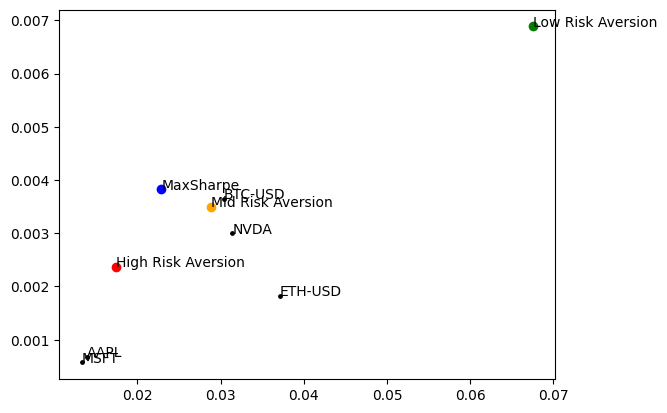

In [47]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(sd, mu, color='black', s=6)
for i, (ix, iy) in enumerate(zip(sd, mu)):
    ax.annotate(both[i], xy=(ix, iy))

W1 = PortfolioWeights(1.0, cov, init_weights, P, Q)
W2 = PortfolioWeights(2.5, cov, init_weights, P, Q)
W3 = PortfolioWeights(5.0, cov, init_weights, P, Q)

risk_low = np.sqrt(W1.T.dot(cv.dot(W1)))
return_low = W1.T.dot(mu)

ax.scatter(risk_low, return_low, color='green')
ax.annotate('Low Risk Aversion', xy=(risk_low, return_low))

risk_mid = np.sqrt(W2.T.dot(cv.dot(W2)))
return_mid = W2.T.dot(mu)

ax.scatter(risk_mid, return_mid, color='orange')
ax.annotate('Mid Risk Aversion', xy=(risk_mid, return_mid))

risk_high = np.sqrt(W3.T.dot(cv.dot(W3)))
return_high = W3.T.dot(mu)

ax.scatter(risk_high, return_high, color='red')
ax.annotate('High Risk Aversion', xy=(risk_high, return_high))

risk_sharpe = np.sqrt(Wshp.T.dot(cv.dot(Wshp)))
return_sharpe = Wshp.T.dot(mu)

ax.scatter(risk_sharpe, return_sharpe, color='blue')
ax.annotate('MaxSharpe', xy=(risk_sharpe, return_sharpe))

plt.show()
    